### Many-body Entanglement and Tensor Networks
Tutorials based on the 2017 Perimeter Scholar International Condensed Matter Review course taught by Guifre Vidal

# <span style="color:#0C45A9">Python tutorial 4</span>

In this tutorial we will use the power method and sparse multiplication method learned in class. The first section of the tutorial (4.1.) will explore how to use this and we will show that we approach the ground-state.<br>
In the second part of the tutorial (4.2.) we will use these methods to increase the number of spins in our simulation with respects to the previous tutorial and observe a reduction in finite size effects.

## 4.1. Power method and sparse multiplication

### 4.1.1. Local $N=2$ quantum Ising Hamiltonian

We define the Hamiltonian for the quantum Ising model as per previous tutorials. We will only build it for $N=2$ and use this in the sparse multiplication method.

In [1]:
import numpy as np

def qIsingH_2(h, bc = 1): #bc = 1 PBC, =-1 APBC
    I = np.eye(2) #2x2 identity matrix
    X = np.array([[0,1],[1,0]]) #Pauli-X
    Z = np.array([[1,0],[0,-1]]) #Pauli-Z
    XX = np.kron(X,X) 
    
    #Hamiltonian for N=2 but with factor of 1/2 in field term since each spin will appear twice
    H = -XX - (h/2)*(np.kron(Z,I) + np.kron(I,Z)) 
    
    return H

In [2]:
H_2 = qIsingH_2(1)

D, U = np.linalg.eig(H_2) #diagonalise fully
E_shift = np.sort(D)[-1]

H_2 -= E_shift*np.eye(4)

### 4.1.2. Sparse multiplication of local Hamiltonian

The function below takes in an arbitrary length vector $\Psi$ and acts on it with the local term $H$, which corresponds to the $N=2$ Ising model Hamiltonian.<br>

This is done by (step 1) reshaping our $2^N$ vector state $\Psi$ into a $(4 \times 2^{N-2})$ matrix so that it can be multiplied by the $(4\times4)$ Hamiltonian $H$. We then (step 2) reshape and transpose the resulting matrix so that all the sites are shifted and we proceed to apply the local Hamiltonain term on all the sites: <br>
<img src="img/sparse_mult.jpg" style="width:400px;height:250px;">

In [3]:
def sparse_multiplication(Psi, H):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    HPsi = np.zeros(L)
    for n in range(1, (N+1)):
        #reshape so that first dimension is 4
        Psi = np.reshape(Psi,(4,2**(N-2)))
        HPsi = np.reshape(HPsi,(4,2**(N-2)))
        #multiply
        HPsi += H.dot(Psi)     
        
        Psi = np.reshape(Psi,(2,2**(N-1)))
        HPsi = np.reshape(HPsi,(2,2**(N-1)))
        Psi = Psi.transpose(1,0)
        HPsi = HPsi.transpose(1,0)
    
    HPsi = np.reshape(HPsi, L)
    return HPsi

### 4.1.3. Power method

In [4]:
def power_method(num_steps, Psi, H_2):
    E_evolution = []
    for step in range(num_steps):
        HPsi = sparse_multiplication(Psi, H_2)
        E_step = np.real((Psi.conj().T).dot(HPsi))
        E_evolution.append(E_step)
        Psi = HPsi/np.linalg.norm(HPsi)
    return np.array(E_evolution)

### 4.1.4. Evaluate and plot

In [5]:
N = 20
Psi_0 = np.random.rand(2**N)
Psi_0 = Psi_0/np.linalg.norm(Psi_0)

num_steps = 30
E_evolution = power_method(num_steps, Psi_0, H_2)
E_evolution += E_shift*N

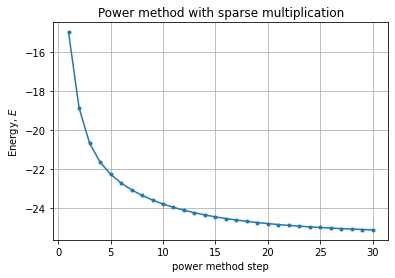

In [6]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.title("Power method with sparse multiplication")
plt.grid()
plt.ylabel("Energy, $E$")
plt.xlabel("power method step")
plt.plot(np.arange(1,num_steps+1), E_evolution, ls = '-', marker = '.')
plt.rcParams["figure.figsize"] = (11,8)
plt.show()

## 4.2. Lanczos method and conformal data

### 4.2.1. Sparse multiplication of $H+T$

As in Tutorial 3, we define our Hamiltonian to be a linear combination of $H$ and $T$. We will do the same here and multiply this by $\Psi$.

In [7]:
def sparse_multiplication_TH(Psi):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    HPsi = np.zeros(L)
    for n in range(1, (N+1)):
        Psi = np.reshape(Psi,(4,2**(N-2)))
        HPsi = np.reshape(HPsi,(4,2**(N-2)))
        HPsi += H_2.dot(Psi)                 
        Psi = np.reshape(Psi,(2,2**(N-1)))
        HPsi = np.reshape(HPsi,(2,2**(N-1)))
        Psi = Psi.transpose(1,0)
        HPsi = HPsi.transpose(1,0)
    
    TPsi = np.reshape(Psi,(2,2**(N-1)))
    TPsi = TPsi.transpose(1,0) #action of T 
    TPsi = np.reshape(TPsi, L)
    
    HPsi = np.reshape(HPsi, L)
    
    HPsi_f = HPsi + 0.001*TPsi
    return HPsi_f

### 4.2.2. Functions to evaluate $E_{\alpha}$, $k_{\alpha}$, $p_{\alpha}$

As in Tutorial 3 this is: <br>
<center>$E = \langle \Psi_{\alpha}|~H~|\Psi_{\alpha}\rangle,~~~~ k = angle(\langle \Psi_{\alpha}|~T~|\Psi_{\alpha}\rangle), ~~~~ p=\frac{(1-\langle \Psi_{\alpha}|~S~|\Psi_{\alpha}\rangle)}{2}$

In [8]:
def evaluate_E(Psi, H):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    HPsi = np.zeros(L)
    H = H.astype('complex128')
    for n in range(1, (N+1)):
        Psi = np.reshape(Psi,(4,2**(N-2)))
        HPsi = np.reshape(HPsi,(4,2**(N-2)))
        HPsi = HPsi+ H.dot(Psi)                 
        Psi = np.reshape(Psi,(2,2**(N-1)))
        HPsi = np.reshape(HPsi,(2,2**(N-1)))
        Psi = Psi.transpose(1,0)
        HPsi = HPsi.transpose(1,0)
    
    Psi = np.reshape(Psi, L)
    HPsi = np.reshape(HPsi, L)
    
    E = np.real(Psi.conj().T.dot(HPsi))
    
    return E

In [9]:
def evaluate_k(Psi):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    TPsi = np.reshape(Psi, (2,2**(N-1)))
    TPsi = TPsi.transpose(1,0) #action of T operator
    TPsi = np.reshape(TPsi, L)
    
    k = np.angle(Psi.conj().T.dot(TPsi))

    return k

In [10]:
def evaluate_p(Psi):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    SPsi = Psi
    Z = np.array([[1,0],[0,-1]])
    
    for n in range(1, (N+1)):
        SPsi = np.reshape(SPsi,(2,2**(N-1)))
        SPsi = Z.dot(SPsi)               
        SPsi = SPsi.transpose(1,0)
    
    SPsi = np.reshape(SPsi, L)
    
    p = np.round((1 - np.real(Psi.conj().T.dot(SPsi)))/2)
    
    return p

### 4.2.3. Sparse diagonalisation of a linear operator

The sparse eigenvalue solving function _scipy.sparse.linalg.eigs()_ does not need to know the individual entries of a matrix to solve the linear system. IT only require the computation of matrix vector products, $Av$ where $v$ is a dense vector. The Python class _scipy.sparse.linalg.LinearOperator_ serves as an abstract interface between iterative solvers and matrix-like objects.

In [11]:
N = 20

from scipy.sparse.linalg import LinearOperator
TH = LinearOperator((2**N,2**N), matvec = sparse_multiplication_TH)

In [12]:
num_states = 12
from scipy.sparse.linalg import eigs
D, Psi = eigs(TH, k = num_states, which = 'LM')

In [13]:
E = []
k = []
p = []

for state in range(num_states):
    E.append(evaluate_E(Psi[:,state], H_2))
    k.append(evaluate_k(Psi[:,state]))
    p.append(evaluate_p(Psi[:,state]))
    
#sort from smaller to largest
ord_idx = np.argsort(E)
E = np.array(E)[ord_idx]
k = np.array(k)[ord_idx] 
p = np.array(p)[ord_idx]

print("Ground-state energy:", E[0])

Ground-state energy: -53.77526093383039


### 4.2.4. Theoretical and numerical CFT data

It is true for any CFT that $\Delta_0 = S_0 = 0$ and $\Delta_T = S_T = 2$ (corresponding to stress-energy tensor). <br>
We can also use the relation: ${\Delta_{\alpha} = (\Delta_T-\Delta_0)\frac{E_{\alpha}-E_0}{E_T-E_0}+\Delta_0} = 2\frac{E_{\alpha}-E_0}{E_T-E_0}$ to find the resting scaling dimensions

In [14]:
k_T = 4*np.pi/N

#obtain the eigenstate number corresponding to k_T to obtain E_T
N_T = 0
for n in range(num_states):
    if abs(k[n]-k_T) < 1e-4:
        if N_T == 0:
            N_T = n
print("Stress-energy tensor eigenvalue number:", N_T)

Stress-energy tensor eigenvalue number: 5


In [15]:
scaling_dim = 2*(E-E[0])/(E[N_T]-E[0])
conf_spin = k/(2*np.pi)*N
print('Scaling dimension: %s \nConformal spin: %s' %(scaling_dim, conf_spin))

Scaling dimension: [0.         0.1259684  1.00619396 1.1290606  1.1290606  2.
 2.         2.         2.         2.10745334 2.10745334 2.1321528 ] 
Conformal spin: [ 0.  0.  0.  1. -1.  2. -2.  1. -1.  2. -2.  0.]


In [16]:
th_scaling_dim = [0, 1/8, 1, 1+1/8, 1+1/8, 2, 2, 2, 2, 2+1/8, 2+1/8, 2+1/8]
th_parity = [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]
th_conf_spin = [0,  0,  0,  1, -1,  2, -2,  1, -1,  2, -2,  0]

###  4.2.5. Plot theory vs numerical CFT data comparison

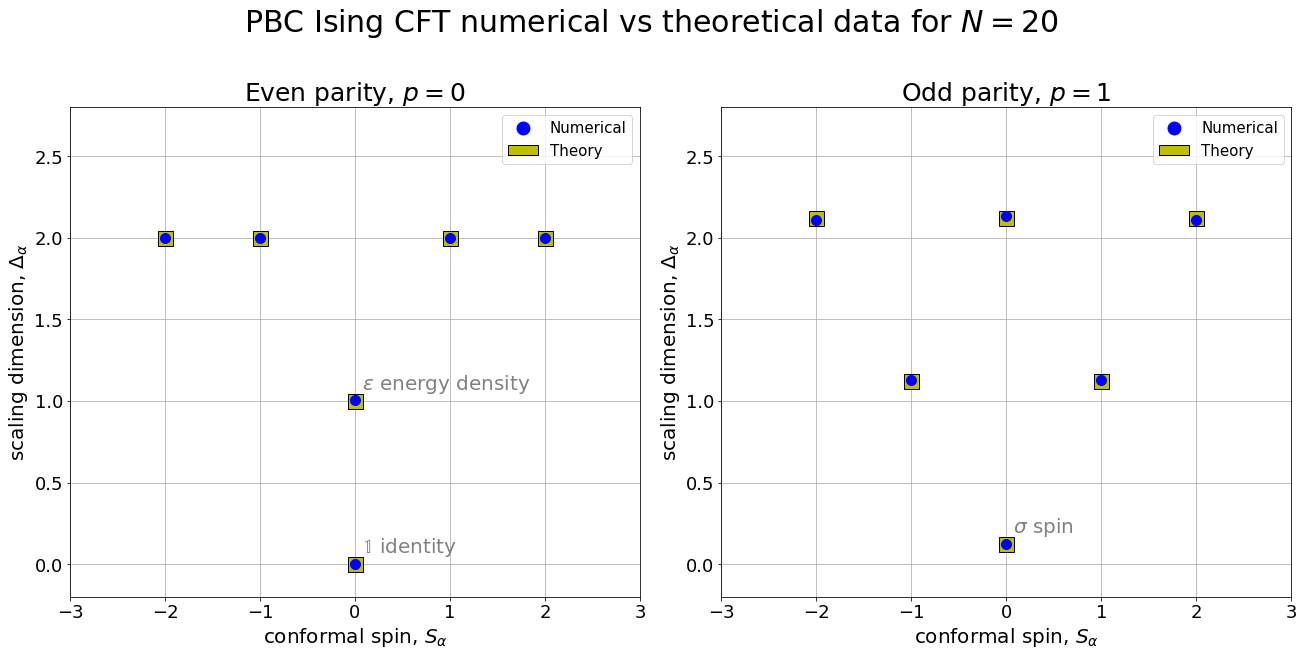

In [17]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", figsize=(18, 9))
fig.suptitle(r'PBC Ising CFT numerical vs theoretical data for $N=20$'+' \n', fontsize=30)
ax1.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax2.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax1.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax2.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax1.set_title(r'Even parity, $p=0$', fontsize=25)
ax2.set_title(r'Odd parity, $p=1$', fontsize=25)
ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax1.grid()
ax2.grid()
ax1.set_xlim([-3, 3])
ax2.set_xlim([-3, 3])
ax1.set_ylim([-0.2, 2.8])
ax2.set_ylim([-0.2, 2.8])
ax1.text(0.07,1.07,r"$\epsilon$ energy density", fontsize=20, color='grey')
ax1.text(0.07,0.07,r"$\mathbb{1}$ identity", fontsize=20, color='grey')
ax2.text(0.07,1/8+0.07,r"$\sigma$ spin", fontsize=20, color='grey')

for i in range(len(th_parity)):
    if th_parity[i] == 0:
        ax1.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)
    elif th_parity[i] == 1:
        ax2.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)


for i in range(num_states):
    if p[i] == 0:
        ax1.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)
    elif p[i] == 1:
        ax2.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Numerical',
                          markerfacecolor='b', markersize=15),
                   Patch(facecolor='y', edgecolor='black',
                         label='Theory')]

        
ax1.legend(handles=legend_elements, fontsize=15)
ax2.legend(handles=legend_elements, fontsize=15)